## Optimization Techniques in Machine Learning

### Case Study - Anonymity by Design

The goal of this project is to develop a **classification model** that detects whether a person's face is **identifiable** by facial recognition technology or has been **obscured**, to evede detection, particularly in protest situations in Kenya.


### Implementation
This notebook details the training of 5 models, 4 using neural network architecture and the other one implemented using ---- algorithm. 


### Dataset
The models are trained on two datasets; 
1. Specs of Faces dataset that has 42,592 images with various face occlusions, offers a challenging environment for face detection and recognition algorithms, assessing their robustness against evasion techniques. It can be found here: https://sites.google.com/view/sof-dataset?pli=1


2. FFHQ dataset that complements the SoF dataset and contains 70,000 images that include as many attributes as possible. It can be found here: https://datasets.activeloop.ai/docs/ml/datasets/ffhq-dataset/





In [2]:
import cv2
import os
import hub
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
INPUT_SHAPE = (128, 128, 3) 
NUM_CLASSES = 2 
BATCH_SIZE = 16 
EPOCHS = 10 

tf.random.set_seed(42)
np.random.seed(42)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.10) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
# LOADING THE SoF DATASET; MATCHING METADATA TO IMAGE

# Import functions from the data_utils.py 
from data_utils import load_image, load_metadata, parse_metadata_entry, match_metadata_to_image

# Paths
image_folder = r"C:\Users\user\SoF\whole_images"
metadata_path = r"C:\Users\user\SoF\metadata.mat"
image_filename = "AbdA_00001_m_31_i_fr_nc_no_2016_2_e0_Gn_h.jpg"

# Load data
image = load_image(image_folder, image_filename)
metadata = load_metadata(metadata_path)

# Parse metadata
metadata_array = metadata['metadata']
parsed_metadata = []
for entry in metadata_array[0]:
    parsed_entry = parse_metadata_entry(entry)
    if parsed_entry:
        parsed_metadata.append(parsed_entry)

# Match metadata to image
matched_metadata = match_metadata_to_image(image_folder, image_filename, parsed_metadata)
if matched_metadata:
    print(f"Metadata for {image_filename}: {matched_metadata}")
else:
    print(f"No metadata found for {image_filename}")

Image loaded successfully: (480, 640, 3)
Metadata for AbdA_00001_m_31_i_fr_nc_no_2016_2_e0_Gn_h.jpg: {'subject_id': 'AbdA', 'image_id': '00001', 'gender': 'm', 'age': 31, 'lighting': 'i', 'frontal': 'fr', 'cropped': 0, 'estimated_points': 1, 'year': 2016, 'difficulty': '2', 'emotion': 1, 'glasses_type': 0, 'facial_landmarks': [336.5, 171.77272727272725, 350.31818181818187, 172.5, 325.59090909090907, 174.68181818181813, 284.1363636363636, 174.68181818181813, 296.5, 175.40909090909088, 271.04545454545456, 176.13636363636363, 338.6818181818182, 231.40909090909088, 288.5, 233.59090909090907, 313.95454545454544, 229.2272727272727, 312.5, 243.77272727272722, 361.9545454545454, 168.13636363636363, 257.95454545454544, 170.31818181818176, 312.5, 270.68181818181813, 311.77272727272725, 107.77272727272725, 313.95454545454544, 205.2272727272727, 332.1363636363636, 208.13636363636363, 297.95454545454544, 210.31818181818176], 'face_rectangle': [0, 0, 0, 0], 'glasses_rectangle': [251.63342898134863, 

In [ ]:
%pip install hub

In [4]:
# LOADING THE FFHQ DATASET

ds = hub.load("hub://activeloop/ffhq", check_integrity=True)
print(ds)

|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ffhq



-

hub://activeloop/ffhq loaded successfully.

Dataset(path='hub://activeloop/ffhq', read_only=True, tensors=['images_1024/face_landmarks', 'images_1024/image', 'images_128/image', 'images_metadata', 'images_wild/face_landmarks', 'images_wild/face_quad', 'images_wild/face_rect', 'images_wild/image'])


### Data Preprocessing

In [5]:
# 1. DETERMINE SUBSET OF IMAGES
# FFHQ
ffhq_images_subset = ds["images_1024/image"][:1700].numpy()

# SoF
sof_images_path = image_folder
def load_image_subset(sof_images_path, num_images=1700):
    images = []
    for image_filename in os.listdir(sof_images_path)[:num_images]:
        if image_filename.endswith(".jpg") or image_filename.endswith(".png"):
            image_path = os.path.join(sof_images_path, image_filename)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
    return images

sof_images_subset = load_image_subset(sof_images_path, num_images=1700)

# 2. PREPROCESS
# Resize images
def preprocess_images(images, size=(128, 128)):
    resized_images = [cv2.resize(img, size) for img in images]
    return np.array(resized_images)

# Preprocess subsets
sof_images_preprocessed = preprocess_images(sof_images_subset)
ffhq_images_preprocessed = preprocess_images(ffhq_images_subset)

# 3. COMBINE
# Combine datasets
X = np.concatenate([sof_images_preprocessed, ffhq_images_preprocessed])
y = np.concatenate([np.zeros(len(sof_images_preprocessed)), np.ones(len(ffhq_images_preprocessed))])

# 4. SPLIT INTO TRAINING, VALIDATION, AND TEST SETS
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 5. DATA AUGMENTATION
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0, 
    width_shift_range=0.05, 
    height_shift_range=0.2,
    shear_range=0.05, 
    zoom_range=0.05, 
    horizontal_flip=True,  
    fill_mode='reflect'  
)

# No augmentation for validation/test data (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create generators for training, validation, and test data
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

# 6. SAVE PREPROCESSED DATA (ORIGINAL SPLITS)
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

print("Preprocessing complete! Data saved to disk.")

Preprocessing complete! Data saved to disk.


In [31]:
# CHECKING FOR DUPLICATES TO AVOID DATA LEAKAGE
import hashlib

def hash_images(images):
    return {hashlib.md5(img.tobytes()).hexdigest() for img in images}

train_hashes = hash_images(X_train)
val_hashes = hash_images(X_val)
test_hashes = hash_images(X_test)

# Find duplicates
print("Train-Val Overlap:", train_hashes & val_hashes)
print("Train-Test Overlap:", train_hashes & test_hashes)
print("Val-Test Overlap:", val_hashes & test_hashes)


Train-Val Overlap: set()
Train-Test Overlap: set()
Val-Test Overlap: set()


## Model Architecture

In [6]:
# Load saved preprocessed data
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

#### Helper functions for plotting, evaluation and error analysis

In [41]:
def plot_loss_curves(history):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print metrics."""
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_probs)  # Use y_pred_probs directly
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot ROC curve
    if NUM_CLASSES == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

def analyze_errors(model, X_test, y_test):
    """Analyze misclassified examples."""
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    misclassified_indices = np.where(y_pred != y_test)[0]
    print(f"Number of misclassified examples: {len(misclassified_indices)}")
    
    # Plot some misclassified examples
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices[:9]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

#### Model building fuction that is customisable

In [43]:
def build_model(input_shape, optimizer='adam', learning_rate=0.001, 
                regularizer=None, dropout_rate=0.2, use_auc=True):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, 
                      kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(dropout_rate), 

        layers.GlobalAveragePooling2D(),  # Instead of Flatten()

        layers.Dense(64, activation='relu', kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),

        layers.Dense(1, activation='sigmoid')
    ])
    
    optimizers_dict = {
        'adam': optimizers.Adam(learning_rate=learning_rate),
        'rmsprop': optimizers.RMSprop(learning_rate=learning_rate),
        'adamw': optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4),
        'nadam': optimizers.Nadam(learning_rate=learning_rate),
        'sgd': optimizers.SGD(learning_rate=learning_rate)
    }
    opt = optimizers_dict.get(optimizer)
    if opt is None:
        raise ValueError("Unsupported optimizer. Choose from 'adam', 'rmsprop', 'adamw', 'nadam', 'sgd'.")
    
    metrics = ['accuracy']
    if use_auc:
        metrics.append(tf.keras.metrics.AUC(name="auc"))
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model


#### Model 1: No optimization

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,305 (14.14 MB)

 Trainable params: 3,706,113 (14.14 MB)

 Non-trainable params: 192 (768.00 B)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 683ms/step - accuracy: 0.9664 - auc: 0.9862 - loss: 0.3761 - val_accuracy: 0.8706 - val_auc: 0.9294 - val_loss: 1.0848
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 682ms/step - accuracy: 0.9984 - auc: 0.9992 - loss: 0.0141 - val_accuracy: 0.9765 - val_auc: 0.9980 - val_loss: 0.0895
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 671ms/step - accuracy: 0.9938 - auc: 0.9952 - loss: 0.2306 - val_accuracy: 0.9961 - val_auc: 0.9980 - val_loss: 0.0813
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 684ms/step - accuracy: 0.9996 - auc: 0.9996 - loss: 0.0157 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 8.5592e-10
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 728ms/step - accuracy: 0.9966 - auc: 0.9977 - loss: 0.1084 - val_accuracy: 0.8294 - val_auc: 0.8373 - val_loss: 8.7229
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 701ms/step - accuracy: 0.9973 - auc: 0.9985 - loss: 0.0232 - val_accuracy: 0.9745 - val_auc: 0.9941 - val_loss: 0.5898
Epoch 7/20
75/75 ━━━━━━━━━━━━━

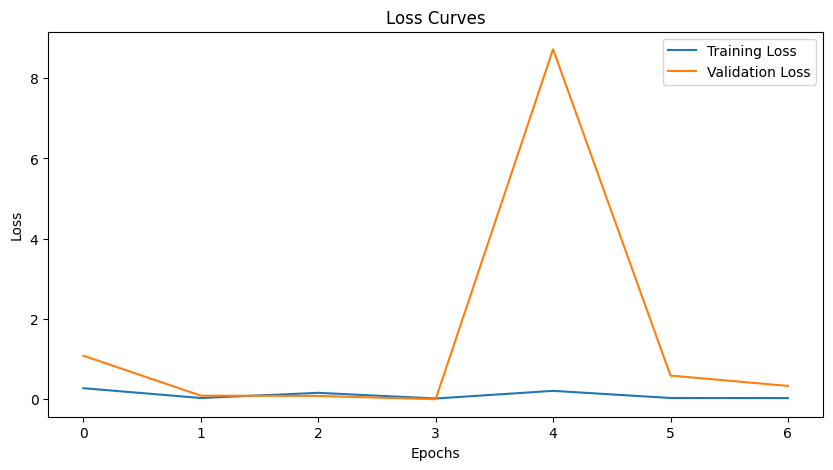

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
Number of misclassified examples: 42


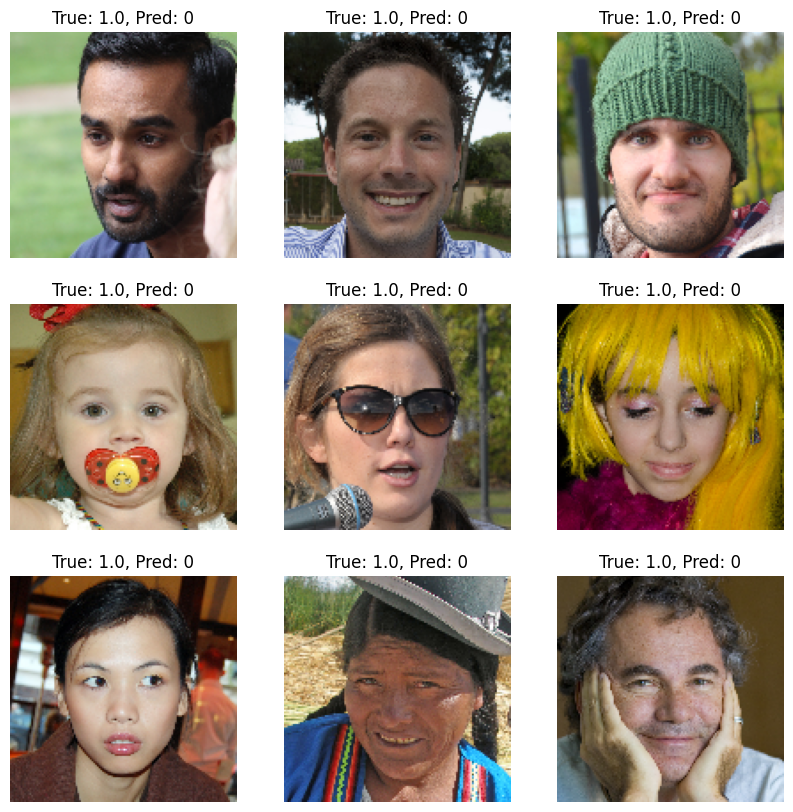

In [11]:
# Build Model 1 (Plain)
model_1 = build_model(INPUT_SHAPE)  # No regularization or dropout
model_1.summary()

# Train Model 1 with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, 
    callbacks=[early_stopping],
    verbose=1
)

print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}")

# Evaluate Model 1
print("Model 1: Plain (No Optimization)")
evaluate_model(model_1, X_test, y_test)
plot_loss_curves(history_1)
analyze_errors(model_1, X_test, y_test)

##### Observations:

1. Overfitting detected, although better (91.76%), the previous iterations had 100% accuracy both val and test

2. High variance in loss (validation loss spiking)

3. Val loss explosion at epoch 5 suggests instability (potential exploding gradients)

#### Model 2: L1/L2 Regularization + SGD Optimizer

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6215 - auc: 0.6881 - loss: 0.7204 - val_accuracy: 0.5627 - val_auc: 0.7312 - val_loss: 0.7149
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7019 - auc: 0.7908 - loss: 0.6345 - val_accuracy: 0.6569 - val_auc: 0.7998 - val_loss: 0.6792
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7781 - auc: 0.8569 - loss: 0.5778 - val_accuracy: 0.7647 - val_auc: 0.8806 - val_loss: 0.6268
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8107 - auc: 0.8821 - loss: 0.5441 - val_accuracy: 0.8216 - val_auc: 0.9352 - val_loss: 0.5744
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8429 - auc: 0.9163 - loss: 0.5000 - val_accuracy: 0.8824 - val_auc: 0.9654 - val_loss: 0.5235
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8782 - auc: 0.9529 - loss: 0.4527 - val_accuracy: 0.9196 - val_auc: 0.9800 - val_loss: 0.4758
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - 

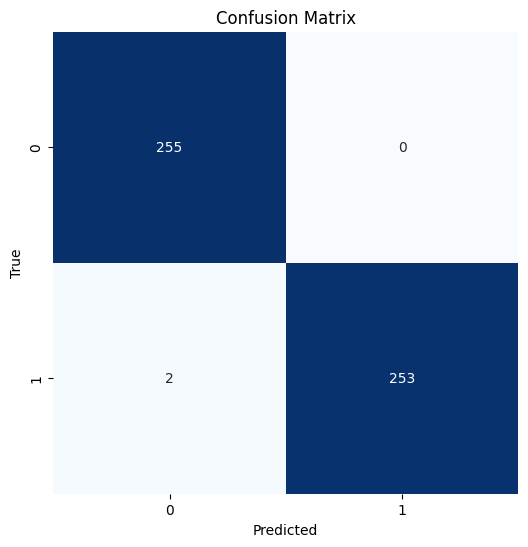

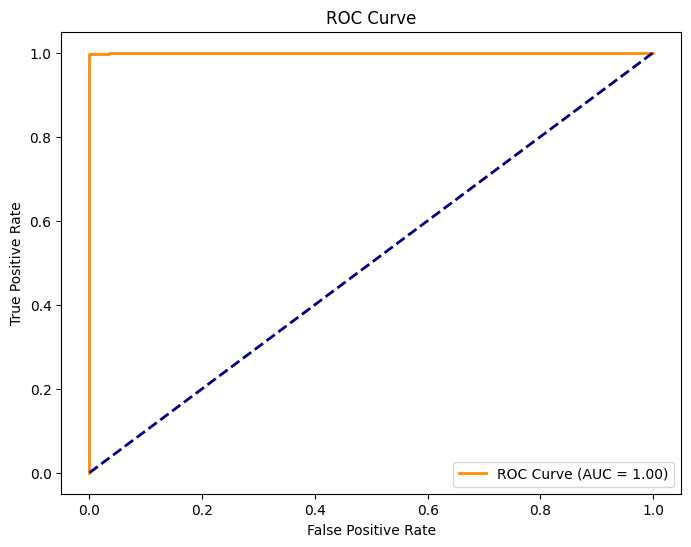

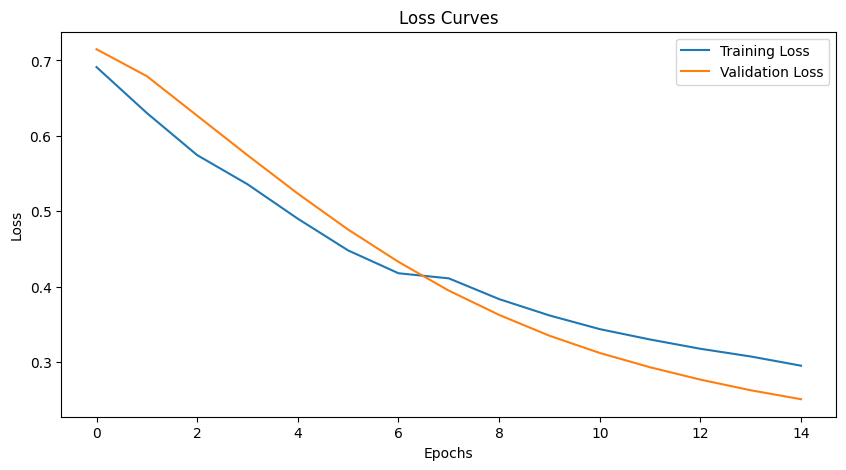

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step
Number of misclassified examples: 2


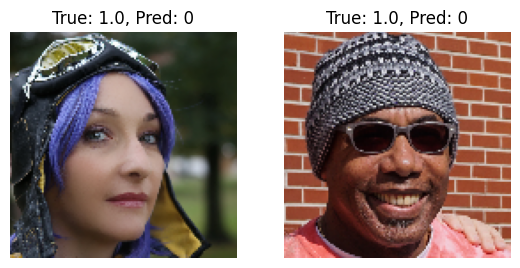

In [47]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5, 
    restore_best_weights=True
)

# Model 2: L1/L2 Regularization
l1_l2_reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)

model_2 = build_model(INPUT_SHAPE, optimizer='sgd', learning_rate=1e-4, 
                      regularizer=l1_l2_reg, dropout_rate=0.5)

model_2.summary()

# Train the model with early stopping
history_2 = model_2.fit(X_train, y_train, 
                         validation_data=(X_val, y_val), 
                         epochs=15, batch_size=64, 
                         callbacks=[early_stopping])

print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}")

# Evaluate Model 2
print("Model 2: L1/L2 Regularization + SGD")
evaluate_model(model_2, X_test, y_test)
plot_loss_curves(history_2)
analyze_errors(model_2, X_test, y_test)

#### Model 3: Adam + L2 Regularization

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8062 - auc: 0.8796 - loss: 0.4447 - val_accuracy: 0.8176 - val_auc: 0.9827 - val_loss: 0.4169
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9971 - auc: 1.0000 - loss: 0.0628 - val_accuracy: 0.9588 - val_auc: 0.9997 - val_loss: 0.2342
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0405 - val_accuracy: 0.9941 - val_auc: 1.0000 - val_loss: 0.1219
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0330 - val_accuracy: 0.9961 - val_auc: 1.0000 - val_loss: 0.0714
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0299 - val_accuracy: 0.9980 - val_auc: 1.0000 - val_loss: 0.0460
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0277 - val_accuracy: 0.9980 - val_auc: 1.0000 - val_loss: 0.0345
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - 

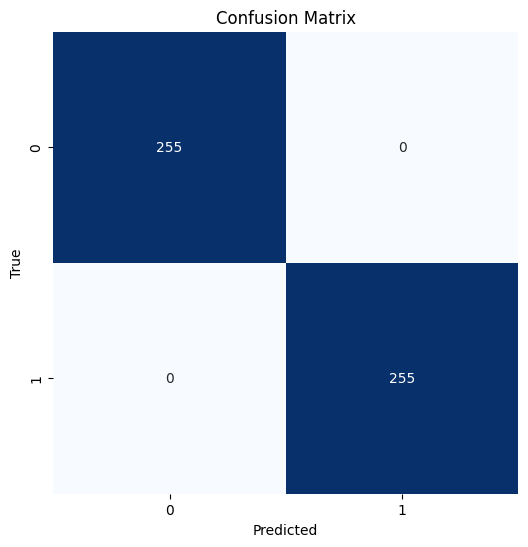

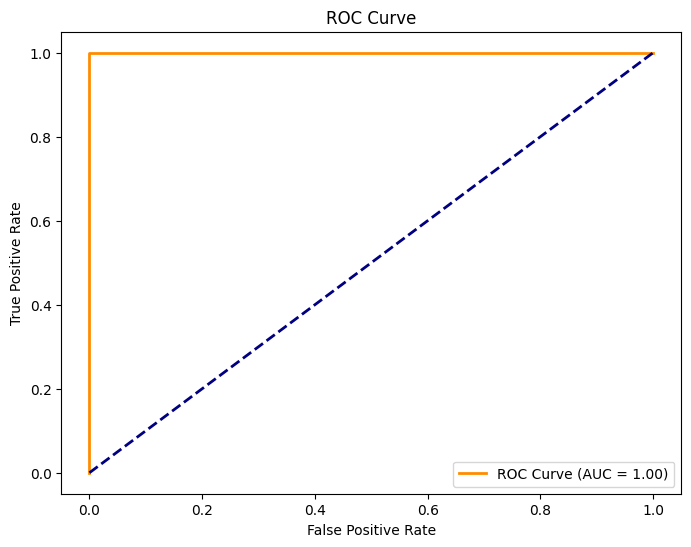

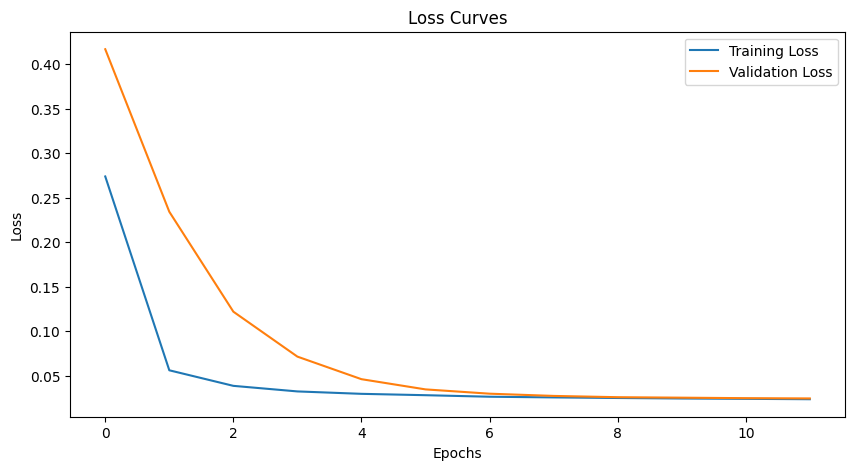

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step
Number of misclassified examples: 0


<Figure size 1000x1000 with 0 Axes>

In [44]:

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5, 
    restore_best_weights=True
)

# Model 3: L2 Regularization + Adam Optimizer
l2_reg = regularizers.l2(1e-4) 

model_3 = build_model(INPUT_SHAPE, optimizer='adam', learning_rate=1e-4, 
                      regularizer=l2_reg, dropout_rate=0.4) 

model_3.summary()

# Train Model 3
history_3 = model_3.fit(X_train, y_train, 
                         validation_data=(X_val, y_val), 
                         epochs=12, batch_size=64,
                         callbacks=[early_stopping])

# Evaluate Model 3
print("Model 3: L2 Regularization + Adam")
evaluate_model(model_3, X_test, y_test)
plot_loss_curves(history_3)
analyze_errors(model_3, X_test, y_test)


#### Model 4: Nadam + L1 Regularization

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9145 - auc: 0.9615 - loss: 0.2670 - val_accuracy: 0.9373 - val_auc: 0.9980 - val_loss: 0.3086
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9983 - auc: 1.0000 - loss: 0.0446 - val_accuracy: 0.9863 - val_auc: 0.9996 - val_loss: 0.1587
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0393 - val_accuracy: 0.9980 - val_auc: 1.0000 - val_loss: 0.0689
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0398 - val_accuracy: 0.9980 - val_auc: 1.0000 - val_loss: 0.0529
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0375 - val_accuracy: 0.9980 - val_auc: 1.0000 - val_loss: 0.0451
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0368 - val_accuracy: 0.9980 - val_auc: 1.0000 - val_loss: 0.0430
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step -

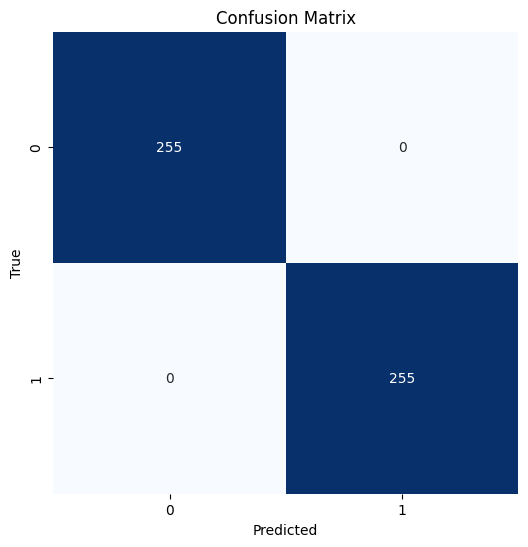

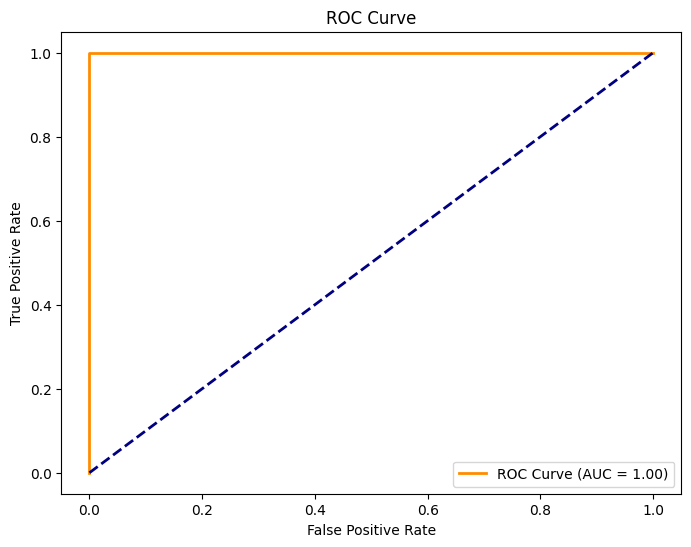

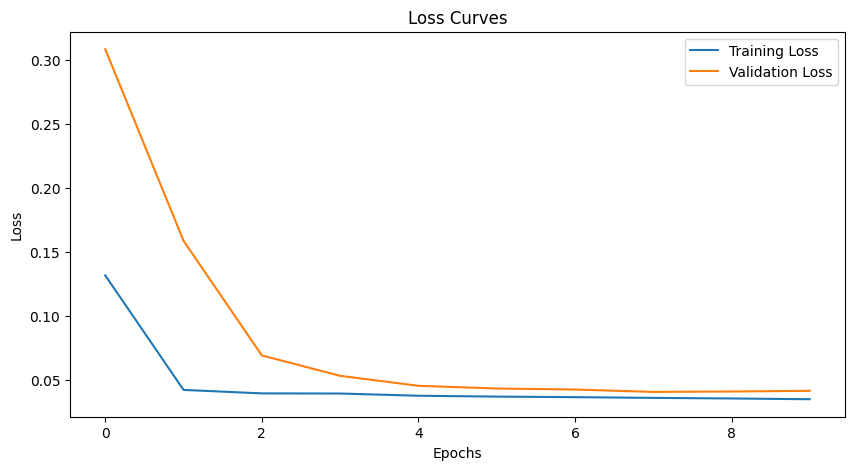

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step
Number of misclassified examples: 0


<Figure size 1000x1000 with 0 Axes>

In [46]:

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5, 
    restore_best_weights=True
)

# Model 4: L1 Regularization + Nadam Optimizer
l1_reg = regularizers.l1(1e-5)

model_4 = build_model(INPUT_SHAPE, optimizer='nadam', learning_rate=5e-4, 
                      regularizer=l1_reg, dropout_rate=0.3) 

model_4.summary()


history_4 = model_4.fit(X_train, y_train, 
                         validation_data=(X_val, y_val), 
                         epochs=10, batch_size=64,
                         callbacks=[early_stopping])


print("Model 4: L1 Regularization + Nadam")
evaluate_model(model_4, X_test, y_test)
plot_loss_curves(history_4)
analyze_errors(model_4, X_test, y_test)


#### Model 5: Logistic Regression

In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Flatten and scale images
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reduce dataset size
X_train_small, _, y_train_small, _ = train_test_split(X_train_scaled, y_train, train_size=0.3, random_state=42)

# Define a hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l2'],  # Remove 'l1' for faster training
    'solver': ['saga']  # 'saga' is better for large datasets
}

# Set up Logistic Regression 
log_reg = LogisticRegression(max_iter=500)

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(log_reg, param_distributions=param_grid, 
                                   n_iter=5, cv=3, scoring='accuracy', 
                                   n_jobs=-1, verbose=1, random_state=42)  

# Train and find best hyperparameters (on reduced dataset)
random_search.fit(X_train_small, y_train_small)

# Best model
best_log_reg = random_search.best_estimator_

# Evaluate model
y_pred = best_log_reg.predict(X_test_scaled)

print("\nOptimized Logistic Regression Performance")
print("Best Hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Optimized Logistic Regression Performance
Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       255
         1.0       1.00      1.00      1.00       255

    accuracy                           1.00       510
   macro avg       1.00      1.00      1.00       510
weighted avg       1.00      1.00      1.00       510



In [9]:
import joblib

save_dir = "saved_models"

# Save the trained logistic regression model
log_reg_path = os.path.join(save_dir, "instance_5_logistic_regression.pkl")
joblib.dump(best_log_reg, log_reg_path)

print(f"Logistic Regression model saved at {log_reg_path}")


Logistic Regression model saved at saved_models\instance_5_logistic_regression.pkl


In [ ]:
import os
from tensorflow.keras.models import save_model

# Save the model
save_path = os.path.join(save_dir, "model_2")
model_2.save(save_path)

print(f"Instance 2 model saved at {save_path}")
